Open on colab for keras and tf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('monthly_milk_production.csv', index_col="Date", parse_dates=True)
# parse dates makes pandas recognize that the Date columns is a datetime object and not a normal string

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

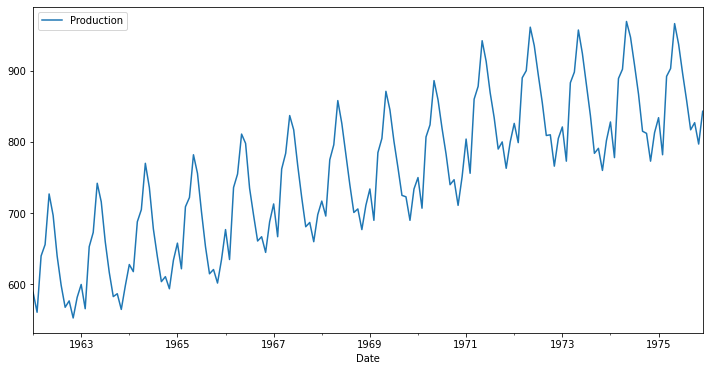

In [ ]:
df.plot(figsize=(12,6))

We note some sort of seasonality and a general trend that is increasing over time.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

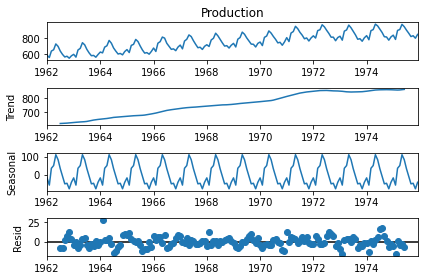

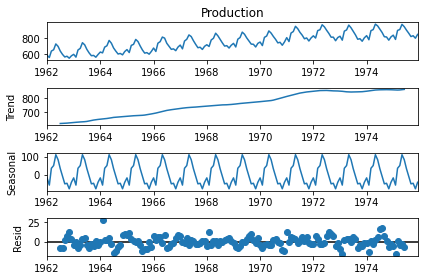

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot()

Observed plot.

Increasing trend over time. 

Seasonal pattern without trend.

Noise, whatever cannot explained by the trend or seasonality.

### Important:

Now normally you should check for stationarity and if your data is non stationary you should make it stationary to fit the model. But in this case we are using a RNN which is able to learn also really complex patterns, therefor it doesn't need stationary data. However, if your model is not able to make good predictions, it could be better to turn your data into stationary since it makes it easier to the model to learn the pattern.

In [ ]:
len(df)

168

In [ ]:
train = df.iloc[:156]       # use all values except the last 12 months
test = df.iloc[156:]        # last 12 months to make the predictions

### **PreProcess the data**

Fundamental for NNs

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

There is difference in the magnitude (from the 5-600 to the 800): this can confuse the model. Therefore it's really useful to convert the data in 0s and 1s.

In [ ]:
scaler.fit(train)                       # fit the scaler on the training set: find the min, max ecc of the training set
scaled_train =scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

#### **Format the data exactly to give to the NN model:**

I'm going to give a sequence of data (like for example 3 or 12 months of data) and that will be the input. Using that, it will give me a prediction for the next month and i will be using that to predict the next further month. Therefor i need to set the input and the desired output. I want to create batches like this to train a NN model.


input -> [1,2,3]

output -> [4]

input: [1,2,3] -> prediction: [4] -> new input: [2,3,4] -> prediction: [5] -> ecc..

Batches in NNs are a subset of the training data that is processed at once during the training process. Instead of feeding the entire dataset into the network at once, which may be computationally expensive or require a large amount of memory, the training data is divided into smaller batches and each batch is processed in sequence.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 3           # 3 months
n_features = 1        # would be more if using multiple time series to make predictions
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
generator[0]

(array([[[0.08653846],
         [0.01923077],
         [0.20913462]]]), array([[0.24759615]]))

In [ ]:
generator[1]

(array([[[0.01923077],
         [0.20913462],
         [0.24759615]]]), array([[0.41826923]]))

In [ ]:
X,y = generator[0]                # extract input (X) and prediction (y) form the first element of the generator
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
[[0.24759615]]


In [ ]:
X.shape     # 1 row, 3 columns, number of features = 1

(1, 3, 1)

Now do the same thing but with 12 months

In [ ]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Define model:

In [ ]:
model = Sequential()                                                          # makes sure that the layers of the RNN are gonna be added in a sequence onee after the other
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))    # 100 neurons, relu activation function, input shape of our data
model.add(Dense(1))                                                           # final output layer which is going to make the final prediction
model.compile(optimizer='adam', loss='mse')                                   # compile the model with the adam optimizer and the mse as the loss function

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


The model is created. Now time for the predictions.

In [ ]:
model.fit(generator, epochs=50)         # fit model, epochs = # of time the ML algorithm will go through the train set

Epoch 1/50
144/144 [==============================] - 2s 5ms/step - loss: 0.0368
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0238
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0195
Epoch 4/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0129
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0202
Epoch 6/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0081
Epoch 7/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 8/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0079
Epoch 9/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 10/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 11/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0048
Epoch 12/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0048
Epoch 13/50
144/144 [====

In [ ]:
model.history.history

{'loss': [0.03679891303181648,
  0.02375202439725399,
  0.019457180052995682,
  0.012922335416078568,
  0.020234867930412292,
  0.008140960708260536,
  0.006596188526600599,
  0.007904203608632088,
  0.0055079106241464615,
  0.004860670305788517,
  0.004837339743971825,
  0.004751591011881828,
  0.0049525294452905655,
  0.0049345907755196095,
  0.006321578286588192,
  0.004250558093190193,
  0.004116950556635857,
  0.004229200072586536,
  0.004640091676265001,
  0.004221624694764614,
  0.003891322296112776,
  0.003850414417684078,
  0.0036137131974101067,
  0.0035107422154396772,
  0.004124743398278952,
  0.004198481794446707,
  0.0034250966273248196,
  0.004744134843349457,
  0.003654526313766837,
  0.003641833085566759,
  0.0047944290563464165,
  0.0029901510570198298,
  0.003289189888164401,
  0.0031724879518151283,
  0.0026979700196534395,
  0.003577175550162792,
  0.002729335566982627,
  0.0031425526831299067,
  0.003726260969415307,
  0.002896876772865653,
  0.0029166352469474077

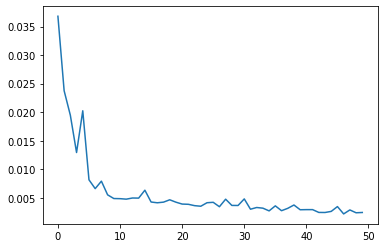

In [ ]:
# plot the loss-per-epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

The loss in mse has been gradually decreasing. The mse is low which is good.

### **Make the predictions:**

Using the scheme provided previously i basically predict the first value of my test set through a 12 month input taken from my train set.

In [ ]:
# Last 12 month values of my training set to make a prediction for the firts value of my test set
last_train_batch = scaled_train[-12:]
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [ ]:
# Before predicting, reshape the data in the X.shape dimension done before
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch.shape

(1, 12, 1)

In [ ]:
X.shape

(1, 3, 1)

In [ ]:
# Prediction for the first value of my test set
model.predict(last_train_batch)

1/1 [==============================] - 0s 163ms/step


array([[0.63620436]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

The two values are really close which is good!

We are now ready to make predictions on the whole test set.

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]                                          # take last 12 values of train set
current_batch = first_eval_batch.reshape((1, n_input, n_features))                  # reshape the first_eval_batch

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]                                  # get prediction for the first batch
    test_predictions.append(current_pred)                                           # append it into the list
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)      # use the pred to update the batch and remove the first value
                                                                                    # np.append(array, values, axis=None)
                                                                                    # since i use axis=1 (append in column) make sure to put the values you append in [[]]

1/1 [==============================] - 0s 19ms/step


In [ ]:
test_predictions

[array([0.63620436], dtype=float32),
 array([0.6282336], dtype=float32),
 array([0.8024469], dtype=float32),
 array([0.879679], dtype=float32),
 array([0.98677415], dtype=float32),
 array([0.96896243], dtype=float32),
 array([0.89648145], dtype=float32),
 array([0.79289603], dtype=float32),
 array([0.6792917], dtype=float32),
 array([0.63177127], dtype=float32),
 array([0.5809332], dtype=float32),
 array([0.6166912], dtype=float32)]

We need to transorm the predictions in orginial scale.

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions
test.head()

<ipython-input-237-7dd3790b1877>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Production,Predictions
Date,,
1975-01-01,834,817.661015
1975-02-01,782,814.345182
1975-03-01,892,886.817911
1975-04-01,903,918.946474
1975-05-01,966,963.498045


<Axes: xlabel='Date'>

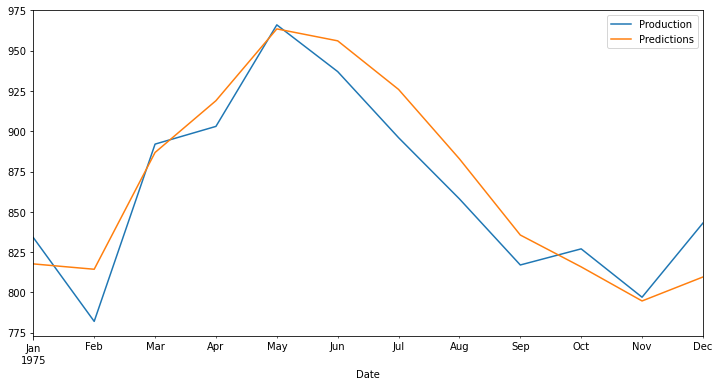

In [ ]:
test.plot(figsize=(12,6))

We note that the predictions do follow the same pattern as the production and the 2 lines are near one another. It looks like that the model has done a good job.

If you want to measure in numbers how good the model has been, I use the RMSE:

In [240]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)

20.562175989117822
